In [1]:
using PyCall
unshift!(PyVector(pyimport("sys")["path"]), "");
@pyimport Compute_Jacobian_Tiergarten

In [2]:
numNodes = Compute_Jacobian_Tiergarten.numNodes;
numLinks = Compute_Jacobian_Tiergarten.numLinks;
numODpairs = Compute_Jacobian_Tiergarten.numODpairs;
numZones = Compute_Jacobian_Tiergarten.numZones
od_pairs = Compute_Jacobian_Tiergarten.od_pairs;
link_list_js = Compute_Jacobian_Tiergarten.link_list_js;
link_length_list = Compute_Jacobian_Tiergarten.link_length_list;

In [3]:
require("../Julia_files/initia_data.jl");
require("prepare_data_Tiergarten.jl");
require("extract_data_Tiergarten.jl");
require("../Julia_files/tap_MSA.jl");
require("../Julia_files/inverseVI.jl");
require("../Julia_files/demands_adjustment_gradi.jl");

In [4]:
demandsDict

Dict{Int64,Dict{(Int64,Int64),Float64}} with 2 entries:
  0 => [(8,23)=>0.86,(21,13)=>9.22,(23,10)=>2.22,(4,5)=>68.44,(18,21)=>11.49,(6…
  1 => [(8,23)=>0.933276841496218,(21,13)=>10.650608598525828,(23,10)=>1.831702…

In [5]:
demandsDiffDict[1] = norm(demandsDicToVec(demandsDict[1]) - demandsDicToVec(demandsDict[0]))/
                     norm(demandsDicToVec(demandsDict[0]));

In [6]:
fcoeffs = [1, 0, 0, 0, 1];

# get observed flow vector (corresponding to ground truth demands and ground truth costs)
tapFlowDicDict[0], tapFlowVecDict[0] = tapMSA(demandsDict[0], fcoeffs);

In [7]:
# get arcs data corresponding to ground truth demands and flows
arcsDict[0] = observFlow("./benchmark_data/Tiergarten_net.txt", tapFlowDicDict[0]);

In [8]:
arcsDict[0]

Dict{(Int64,Int64),Arc} with 766 entries:
  (248,65)  => Arc(248,65,900.0,17.0,494.57000000000005)
  (137,106) => Arc(137,106,2800.0,1.666667,223.97000000000003)
  (267,256) => Arc(267,256,2400.0,7.333333,87.03013)
  (354,353) => Arc(354,353,900.0,1.0,417.47862000000026)
  (56,55)   => Arc(56,55,600.0,0.333333,0.0)
  (259,255) => Arc(259,255,2400.0,0.666667,0.0)
  (125,177) => Arc(125,177,900.0,1.666667,0.0)
  (36,35)   => Arc(36,35,2800.0,0.333333,19.630659999999978)
  (183,184) => Arc(183,184,900.0,0.333333,0.0)
  (43,361)  => Arc(43,361,2800.0,12.666667,6.49019)
  (16,277)  => Arc(16,277,999999.0,0.0,1555.6841500000007)
  (298,307) => Arc(298,307,2400.0,1.0,1531.6967499999982)
  (31,34)   => Arc(31,34,2800.0,0.666667,106.18020999999995)
  (187,191) => Arc(187,191,600.0,0.666667,228.48465)
  (241,244) => Arc(241,244,2400.0,0.333333,0.0)
  (84,95)   => Arc(84,95,900.0,2.333333,0.0)
  (221,2)   => Arc(221,2,999999.0,0.0,740.0510800000003)
  (23,351)  => Arc(23,351,999999.0,0.0,0.0)
  (

In [9]:
deg = 8
c = 1.5
lam = .01

# coeffs_dict[(deg, c, lam, 1)], objInvVIDict[1] = train(lam, deg, c, demandsDict[1], arcsDict[0]);
coeffs_dict[(deg, c, lam, 1)] = fcoeffs;
objInvVIDict[1] = 0;

INFO: Loading help data...


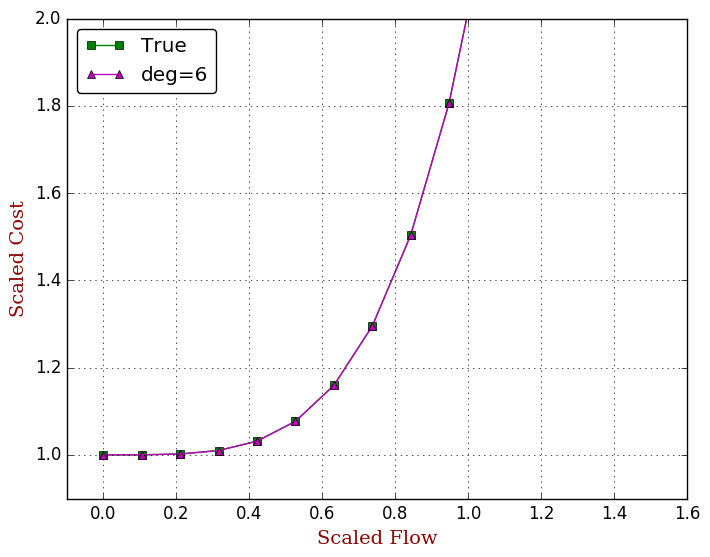

In [10]:
using PyPlot

iterN = 1

true_coeffs = [1, 0, 0, 0, 1]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(deg, c, lam, iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Tiergarten_iter_$(iterN).pdf")

In [11]:
demandsVecDict[1] = demandsDicToVec(demandsDict[1]);
objFunDict[1] = objF(demandsVecDict[1], coeffs_dict[(deg, c, lam, 1)]);

In [12]:
# get initial flow vector (corresponding to initial demands)
tapFlowDicDict[1], tapFlowVecDict[1] = tapMSA(demandsDict[1], coeffs_dict[(deg, c, lam, 1)]);

demandsVecDict[0] = demandsDicToVec(demandsDict[0]);

In [13]:
# get arcs data corresponding to initial demands and flows
arcsDict[1] = observFlow("./benchmark_data/Tiergarten_net.txt", tapFlowDicDict[1]);

In [14]:
linkCostDicDict[1] = tapFlowVecToLinkCostDict(tapFlowVecDict[1], coeffs_dict[(deg, c, lam, 1)]);

In [15]:
linkCostDicDict[1]["0"], link_length_list[1]

(0.0,0.0)

In [16]:
jacobiSpiessDict[1] = Compute_Jacobian_Tiergarten.jacobianSpiess(numNodes, numLinks, numODpairs, od_pairs, 
                                              link_list_js, [linkCostDicDict[1]["$(i)"] for i=0:numLinks-1]);

In [17]:
# maximum number of iterations
N = 100;  

# Armijo rule parameters
rho = 2;
M = 10;

# search direction parameter
epsilon_1 = 0;

# stop criterion parameter
epsilon_2 = 1e-20;

In [18]:
for iterNumber = 1:N
    
    l = iterNumber;
    
    jacobDict[l] = jacobiSpiessDict[l]

    descDirecDict[l] = descDirec(tapFlowVecDict[l], tapFlowVecDict[0], jacobDict[l], numODpairs, numLinks);

    demandsVecDict[l] = demandsDicToVec(demandsDict[l]);

    searchDirecDict[l] = searchDirec(demandsVecDict[l], descDirecDict[l], epsilon_1);

    thetaMaxDict[l] = thetaMax(demandsVecDict[l], searchDirecDict[l]);

    demandsVecDict[l+1] = similar(demandsVecDict[0]);
    
    demandsVecDict[l+1], objFunDict[l+1] = armijo(objFunDict[l], demandsVecDict[l], coeffs_dict[(deg, c, lam, l)], 
    searchDirecDict[l], thetaMaxDict[l], rho, M);
            
    demandsDict[l+1] = demandsVecToDic(demandsVecDict[l+1]);
    
    tapFlowDicDict[l+1], tapFlowVecDict[l+1] = tapMSA(demandsDict[l+1], coeffs_dict[(deg, c, lam, l)]);
        
    arcsDict[l+1] = observFlow("./benchmark_data/Tiergarten_net.txt", tapFlowDicDict[l+1]);
        
#     coeffs_dict[(deg, c, lam, l+1)], objInvVIDict[l+1] = train(lam, deg, c, demandsDict[l+1], arcsDict[0]);
    
    coeffs_dict[(deg, c, lam, l+1)] = fcoeffs;
    objInvVIDict[l+1] = 0;

    linkCostDicDict[l+1] = tapFlowVecToLinkCostDict(tapFlowVecDict[l+1], coeffs_dict[(deg, c, lam, l+1)]);
    
    jacobiSpiessDict[l+1] = Compute_Jacobian_Tiergarten.jacobianSpiess(numNodes, numLinks, numODpairs, od_pairs, 
                                              link_list_js, [linkCostDicDict[l+1]["$(i)"] for i=0:numLinks-1]);
        
    demandsDiffDict[l+1] = norm(demandsVecDict[l+1] - demandsVecDict[0]) / norm(demandsVecDict[0]);
    
    # stopping criterion
    if (objFunDict[l] - objFunDict[l+1]) / objFunDict[1] < epsilon_2
        break
    end
  
end

# normalize objective function value
for l = 1:(length(objFunDict))
    norObjFunDict[l] = objFunDict[l] / objFunDict[1];
end

In [19]:
demandsVecDict

Dict{Any,Any} with 10 entries:
  0 => [22.59,18.32,21.82,15.22,3.73,0.1,0.31,1.22,0.52,0.21,1.52,11.19,19.89,1…
  4 => [23.299626488115535,14.849754465021753,18.078578493730713,14.17032479827…
  7 => [23.268080776897495,14.851436025674344,18.08035541884148,14.160218353964…
  9 => [23.268081651246305,14.851436196473163,18.08035554229578,14.160217669818…
  2 => [23.324200541884203,14.843853185452952,18.07028360611001,14.211528185013…
  3 => [23.344328075097486,14.848365689733022,18.076077642935854,14.18643134004…
  5 => [23.268065069898757,14.851433295190784,18.08035335683153,14.160230735433…
  8 => [23.268081651246305,14.851436196473163,18.08035554229578,14.160217669818…
  6 => [23.268079021362567,14.851435682745588,18.080355170967067,14.16021972759…
  1 => [23.24771725573017,14.70670580559302,18.008669000518786,14.1112743641057…

In [20]:
norObjFunDict

Dict{Any,Any} with 9 entries:
  7 => 0.6499381287145976
  4 => 0.6798938755549278
  9 => 0.6499367142522906
  2 => 0.7817481770690798
  3 => 0.7237786752878491
  5 => 0.6544910567242153
  8 => 0.6499367142522906
  6 => 0.6499409687245336
  1 => 1.0

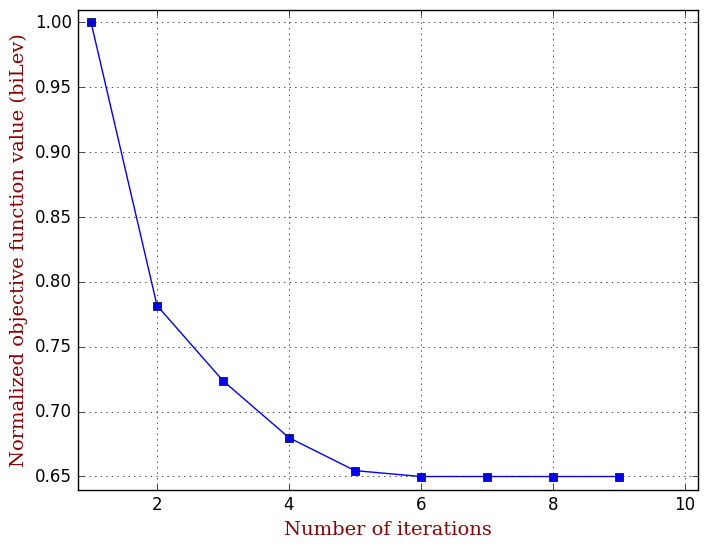

In [21]:
using PyPlot

iterNum = 1:(length(norObjFunDict))

objFun = map(iterNum->norObjFunDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, objFun, "s-b")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(.8, length(norObjFunDict) + 1 + .2)
ylim(minimum(objFun)-.01, maximum(objFun)+.01)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Normalized objective function value (biLev)", fontdict=font1)

savefig("./results/objFun_biLev_Tiergarten.pdf")

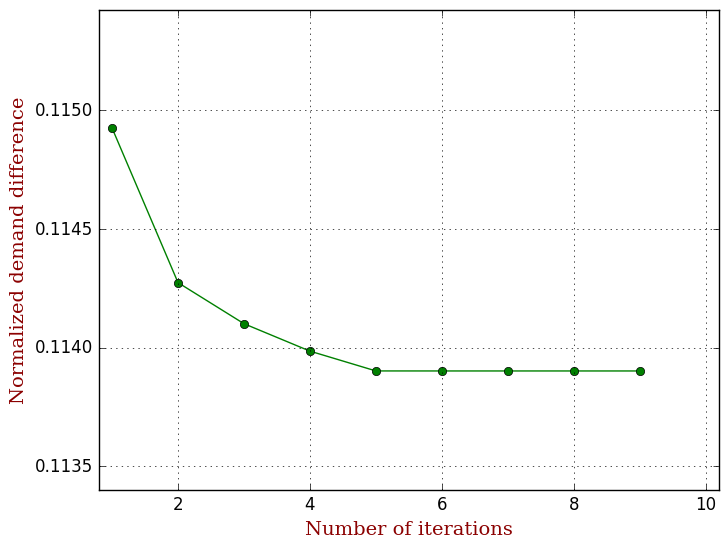

In [22]:
using PyPlot

iterNum = 1:(length(demandsDiffDict))

demandsDiff = map(iterNum->demandsDiffDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, demandsDiff, "o-g")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(.8, length(demandsDiffDict) + 1 + .2)
ylim(minimum(demandsDiff)-.0005, maximum(demandsDiff)+.0005)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Normalized demand difference", fontdict=font1)

savefig("./results/demandsDiff_biLev_Tiergarten.pdf")

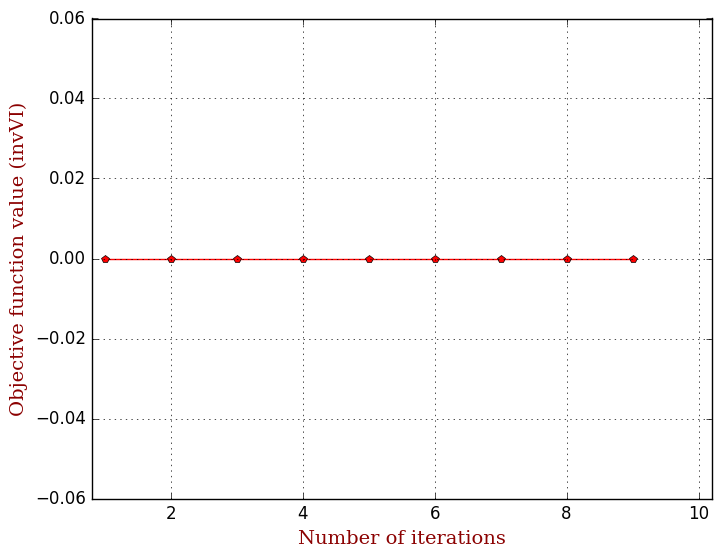

In [23]:
using PyPlot

iterNum = 1:(length(objInvVIDict))

objFun = map(iterNum->objInvVIDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, objFun, "p-r")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(0.8, length(objInvVIDict) + 1 + .2)
# ylim(0.9, 2.0)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Objective function value (invVI)", fontdict=font1)

savefig("./results/objFun_invVI_Tiergarten.pdf")

In [24]:
coeffs_dict

Dict{Any,Any} with 9 entries:
  (8,1.5,0.01,5) => [1,0,0,0,1]
  (8,1.5,0.01,9) => [1,0,0,0,1]
  (8,1.5,0.01,3) => [1,0,0,0,1]
  (8,1.5,0.01,2) => [1,0,0,0,1]
  (8,1.5,0.01,1) => [1,0,0,0,1]
  (8,1.5,0.01,4) => [1,0,0,0,1]
  (8,1.5,0.01,8) => [1,0,0,0,1]
  (8,1.5,0.01,6) => [1,0,0,0,1]
  (8,1.5,0.01,7) => [1,0,0,0,1]

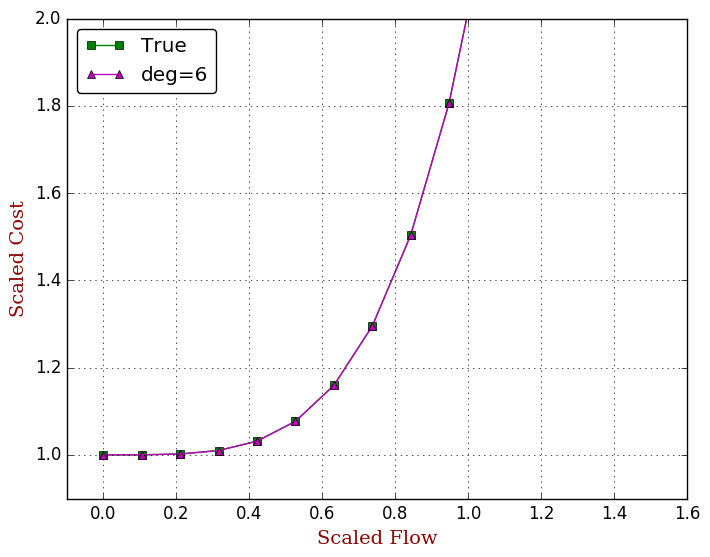

In [25]:
using PyPlot

iterN = 1

true_coeffs = [1, 0, 0, 0, 1]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(deg, c, lam, iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Tiergarten_iter_$(iterN).pdf")

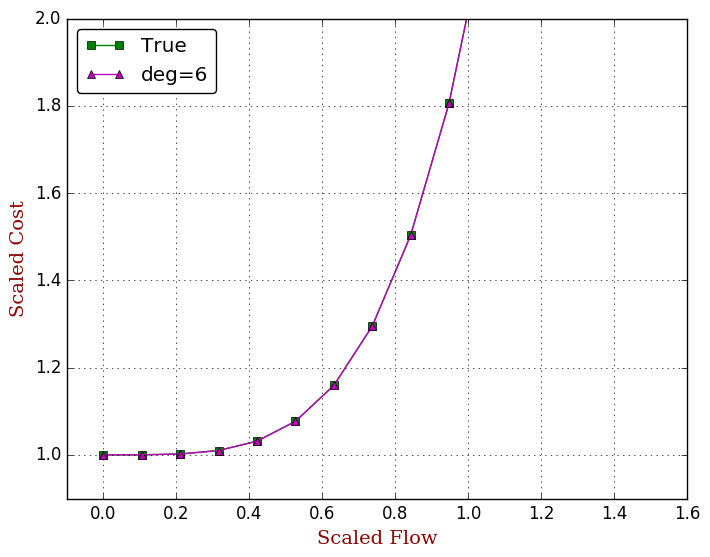

In [26]:
using PyPlot

iterN = 2

true_coeffs = [1, 0, 0, 0, 1]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(deg, c, lam, iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Tiergarten_iter_$(iterN).pdf")

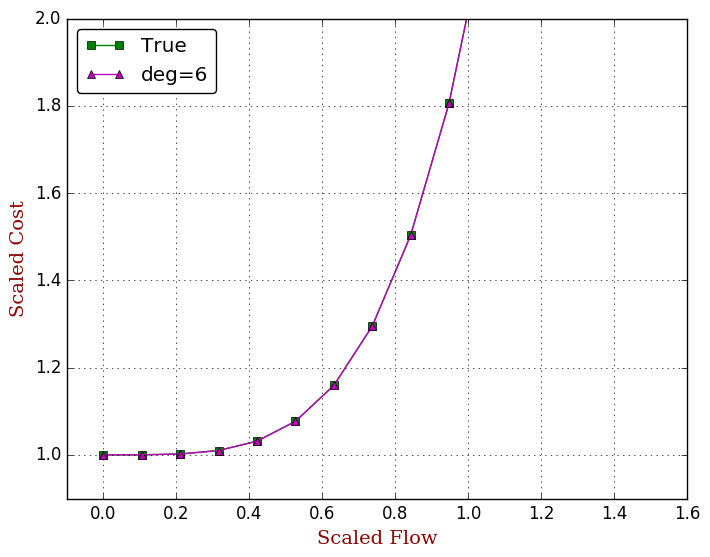

In [27]:
using PyPlot

iterN = 3

true_coeffs = [1, 0, 0, 0, 1]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(deg, c, lam, iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Tiergarten_iter_$(iterN).pdf")

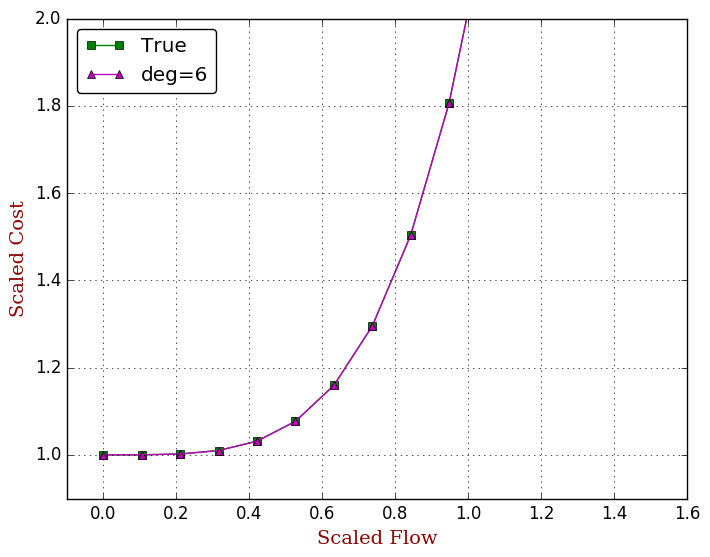

In [28]:
using PyPlot

iterN = length(coeffs_dict)

true_coeffs = [1, 0, 0, 0, 1]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(deg, c, lam, iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Tiergarten_iter_$(iterN).pdf")

In [29]:
outfile = open("./results/norObjFunDict.json", "w")

JSON.print(outfile, norObjFunDict)

close(outfile)

In [30]:
outfile = open("./results/demandsDiffDict.json", "w")

JSON.print(outfile, demandsDiffDict)

close(outfile)

In [31]:
outfile = open("./results/objInvVIDict.json", "w")

JSON.print(outfile, objInvVIDict)

close(outfile)

In [32]:
outfile = open("./results/coeffs_dict.json", "w")

JSON.print(outfile, coeffs_dict)

close(outfile)

In [33]:
outfile = open("./results/demandsVecDict.json", "w")

JSON.print(outfile, demandsVecDict)

close(outfile)

In [34]:
outfile = open("./results/demandsDict.json", "w")

JSON.print(outfile, demandsDict)

close(outfile)

In [35]:
outfile = open("./results/tapFlowDicDict.json", "w")

JSON.print(outfile, tapFlowDicDict)

close(outfile)

In [36]:
outfile = open("./results/tapFlowVecDict.json", "w")

JSON.print(outfile, tapFlowVecDict)

close(outfile)